# Conclusion & Summary of Results

Within this final section I'll provide a summary of the analysis completed within this workbook in addition to visualizations of the data.

In [14]:
import numpy as np
from numpy.linalg import inv

import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import seaborn as sns
from PIL import Image
import plotly.express as px

import dash
from dash import Dash, dcc, html, Input, Output
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

import pycaret

### Data Imports

In [109]:
with open('pickles/df_base.pkl', 'rb') as f:
    df_base = pickle.load(f)
with open('pickles/df_cleaned.pkl', 'rb') as f:
    df_cleaned = pickle.load(f)
with open('pickles/df_engineered.pkl', 'rb') as f:
    df_engineered = pickle.load(f)
with open('pickles/df_engineered.pkl', 'rb') as f:
    df_user = pickle.load(f)
with open('pickles/data_user.pkl', 'rb') as f:
    data_user = pickle.load(f)
with open('pickles/data_user_unseen.pkl', 'rb') as f:
    data_user_unseen = pickle.load(f)
with open('pickles/combined_metrics.pkl', 'rb') as f:
    combined_metrics = pickle.load(f) 

### Analysis Summary

At the outset of this analysis I began with a Dataset compiled by [The Transit Costs Project](https://transitcosts.com/). The Dataset they created spans 54+ countries and totals more than 20,000 km of urban rail built since the late 1960s. In addition to this dataset, I added approximately 50 datapoints from a similar dataset created by [The Eno Center for Transportation](https://enotrans.org/article/eno-releases-first-iteration-of-transit-construction-cost-database/).

The resulting base dataset was approximately 1000 rows and 27 features.

In [36]:
df_base

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,year,ppp_rate,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2021,cost_km_2021
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.30,0,...,2005,0.183704,3435.273387,2642.517990,0.0,0.0,0.0,1.390000,4775.030008,3673.100006
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.00,0,...,1971,0.759851,46.502863,31.001909,0.0,0.0,0.0,6.690000,311.104154,207.402770
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.00,0,...,2013,0.272952,1304.854864,293.423626,0.0,0.0,0.0,1.160000,1513.631643,340.371406
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.00,0,...,2020,0.239311,689.216325,191.448979,0.0,0.0,0.0,1.046980,721.595866,200.443296
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.00,0,...,2006,1.117637,59.234754,59.234754,0.0,0.0,0.0,1.340000,79.374570,79.374570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,ES,Vitoria,2006,2008,0.0,7.2,0.0,0.000,0.00,7.2,...,2006,1.358613,135.861258,18.869619,7.2,0.0,0.0,1.344097,182.610740,25.362603
1029,US,Washington,1993,1999,0.0,4.7,1.0,4.700,0.00,0,...,1993,1.000000,595.562775,127.034144,0.0,0.0,1.0,1.875225,1116.814153,238.217592
1030,US,Washington,1994,1998,0.0,2.5,1.0,2.500,0.00,0,...,1994,1.000000,243.809042,96.218112,0.0,0.0,1.0,1.828408,445.782295,175.925923
1031,US,Washington,1995,2001,0.0,10.7,0.7,7.500,3.22,0.0,...,1995,1.000000,850.337905,79.170049,0.0,0.0,1.0,1.778018,1511.916418,140.765801


From this base dataset, I began preparing the dataset for modelling. This process includes evaluating each feature and removing or ammending rows with missing values. In the case of this analysis, the base dataset was mostly complete, however there were some features with missing values that needed to be handled.

In [37]:
df_base.isna().sum().sort_values(ascending=False).head(5)

platform_len    621
stations         20
rr?               2
country           0
cost              0
dtype: int64

As shown above, the feature for platform length contained many missing values (~60%) of the total rows, while 'stations' & 'rr?' contained minimal missing values. Since there were so many missing values for platform length, and since I didn't believe the feature would be a great predictor of overall construction cost, I dropped 'platform_len'.

The remaining missing values for 'stations' and 'rr?' were filled through a means of unofficial sources and estimates from similar projects or phases of the same project.

As part of this cleaning process, the remainder of the features were cleaned to remove instances where the data didn't make sense, such as negative project durations and misaligned length components.

##### Sheet 3 (Exploratory Data Analysis)

I then needed to evaluate the distributions of the base dataset to help ensure the data quality before proceeding. This process involved looking at the distributions of each individual feature to check if the data made sense.

In [38]:
fig = px.histogram(df, x="length", nbins=100)
fig.show()

The normality of these distributions isn't as important as the edges of the data are. For instance, the above plot shows the distribution of total length values. By looking at the edges we can confirm that there are 1) No erroneous negative length values and 2) several potential outliers above 100km of length. By plotting the distributions for many features, I was able to identify which features I would need to evaluate more closesly.

In this process I realized that many of the PPP rates differed significantly from trustworthy sources, such as [World Bank](https://databank.worldbank.org/metadataglossary/world-development-indicators/series/PA.NUS.PPP). Since the PPP rate can vary significantly over the course of a project, this feature should be considered, at best, an estimate. However I needed a way to programmatically obtain these values without needing to check each value individually.

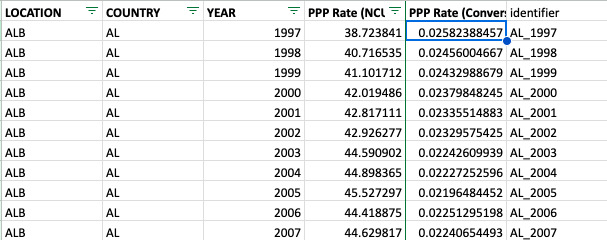

In [39]:
image = Image.open("images/PPPrate.png")
image

To accomplish this, I pulled World Bank's PPP Dataset and used VLookup in Google Sheets to populate the PPP conversion rate. I then merged this data into the primary dataframe. This however was not an exact science as many countries use a foreign currency to fund their projects. Since the PPP rate could be affected by this, I made the decision to convert each currency to the home countries official currency.

Once this information was populated, I began evaluating the target variable for outliers by looking at the cost_per_km feature.

In [40]:
fig = px.histogram(df, x="cost_km", nbins=1000)
fig.show()

As we can see in the above distribution, there are many projects where the cost per km is greater than $1Bn/km. Additionally, there are many values on the left side of the tail that are close to zero. I went about verifying each datapoint individually.

I set aside each value that appeared to be an outlier for use in the refinement stage of this analysis.

##### Sheet 4 (Feature Engineering)

Knowing that my data were complete, I began the feature engineering stage of the analysis. Due to the small size of the dataset, I wanted to generate additional information from the existing data. This additional information may be useful for the model, as the number of rows that the model has to pull from is limited.

Since the dataset contained values for the location (city,country) of each project, I knew I would be able to generate additional data regarding the location of each project. I used the city and country pairs to generate latitude and longitude pairs for each item in the dataset. This allowed me to access more finite information for each project.

The features I generated using the location data were:

- City density (persons per km)
- Country density
- Country poverty rate
- Region name
- Sub-Region name
- Country Gross Domestic Product
- Soil types (Probabilities)
- Elevation
- Union Density (Prevalance of Labor Unions)
- Station Density (Number of stations per km)
- Land Costs (Land aquisition costs)
- Climate Data (Temperatures, precipitation)

Here are some plots to illustrate the importance of these features for the purposes of predicting the cost of a project:

##### Bubble Map of Density

In [55]:
fig = px.scatter_geo(df_engineered, lat='lat', lon='lng', color="city_density",
                     hover_name="country", size="cost_km_2021",
                     projection="natural earth")
fig.show()

Above is a map of all the points in the dataset. This map uses the latitude and longitude generated in the previous step to identify the location for each city. The color of the bubble indicates a city with a larger density and the size indicates a more expensive project, on a 'cost_real_2021' basis.

In many cases, we see that the more expensive projects occur in areas with a higher reported density.

##### Soil Types

In [54]:
fig = px.scatter_geo(df_engineered, lat='lat', lon='lng', color="wrb_class_name",
                     hover_name="country", size="cost_km_2021",
                     projection="natural earth")
fig.show()

Once again, using a map to identify the location of each project, we can get a sense for if a specific soil type may impact the cost to construction a train line in that area. Within this plot, there is no discernable trend, but we'll look at this again later.

##### Union Density

In [65]:
df_engineered['union_density']= df_engineered['union_density'].astype(float)

In [67]:
fig = px.scatter_geo(df_engineered, lat='lat', lon='lng', color="union_density",
                     hover_name="country", size="cost_km_2021",
                     projection="natural earth")
fig.show()

and finally, plotting the union density on the same map to determine if labor union prevalence correlates with construction costs. The purpose of this section was not to find absolute measures of construction costs, but simply to throw things at the wall just to see what sticks.

This small differences between localities may allow the model to find trends in the data and so, by engineering features, the purpose is to create more combinations for the model to search through.

##### Sheet 5 (Pre-Processing & Model First Pass)

After I generated additional features for the dataset, I completed the first model pass for the data. This model pass was intended to identify weaknesses with the model and to identify outliers, not to provide trustworthy predictions. To model the data, I'm using [PyCaret](https://pycaret.gitbook.io/docs/), which is an automation tool for machine learning workflows.

By using PyCaret I can run multiple models at a time to determine which model best suits my data.

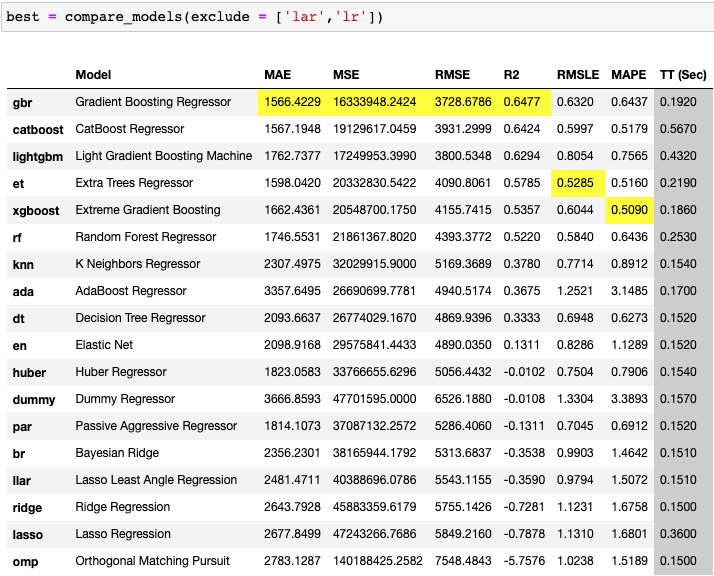

In [68]:
image = Image.open("images/model_first_pass.png")
image

The first pass of the model performed poorly with each model, however it provided valuable insights. Firstly I observed the z_scores generated by the predictions from the first model pass.

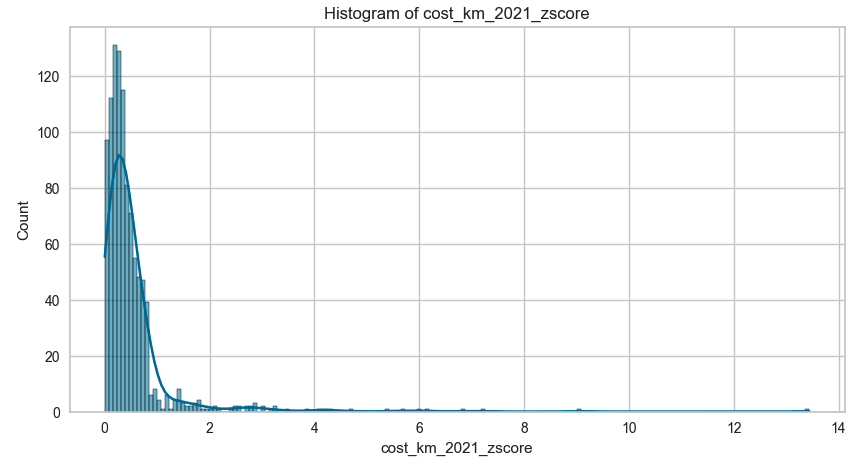

In [70]:
image = Image.open("images/z_scores_first.png")
image

The Z-scores represent the number of standard deviations a given data point is from the mean of a set of data. It's a way to quantify how far away a specific observation is from the average, relative to the spread (standard deviation) of the dataset. So by plotting the distribution of the Z-scores, I can identify how many points are outliers by looking at how many points are outside of 2 (or 3) standard deviations from the mean. (in the above plot, that's a lot of them)

The above Z-score distribution was completed for each important feature (length,tunnel,density, etc.) and the index of outliers were saved into a list. An additional check was completed to evaluate the Interquartile range for each important feature.

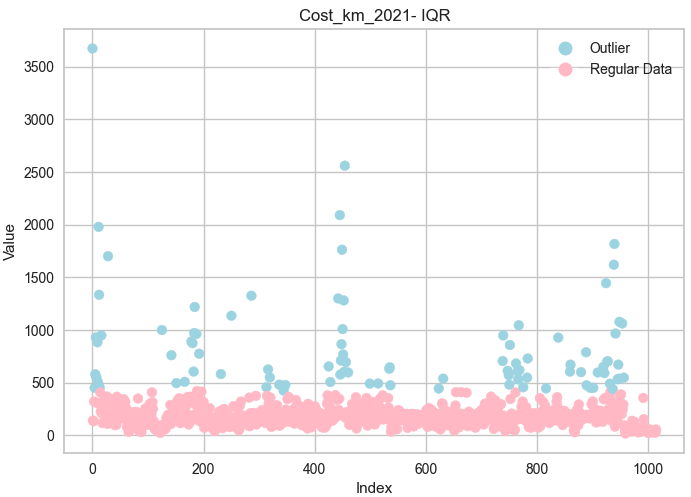

In [71]:
image = Image.open("images/IQR_first.png")
image

The IQR is a measure of statistical dispersion or spread in a dataset. It's the difference between the third quartile (Q3) and the first quartile (Q1). The IQR gives us the range within which the central 50% of the values lie. We can use the first and third quartiles to identify outliers, as any of the values that fall outside of the "inner fences" or "outer fences" defined by the IQR should be looked at. In this case I again collected indices for outliers within the IQR plots for each feature and saved them to a seperate list.

##### Sheet 6 (Refining Data)

It's important to note that my first goal with outliers is not to remove the outlier, but to identify why it's an outlier. Many outliers may be erroneous, but I first need to determine why it's erroneous and try to correct the data before I consider removing the point.

Within the data refinement process I started with the list of outliers generated in the prevous step. I organized each outlier based on the country of origin and verified each outlier individually. My workflow looked like this:

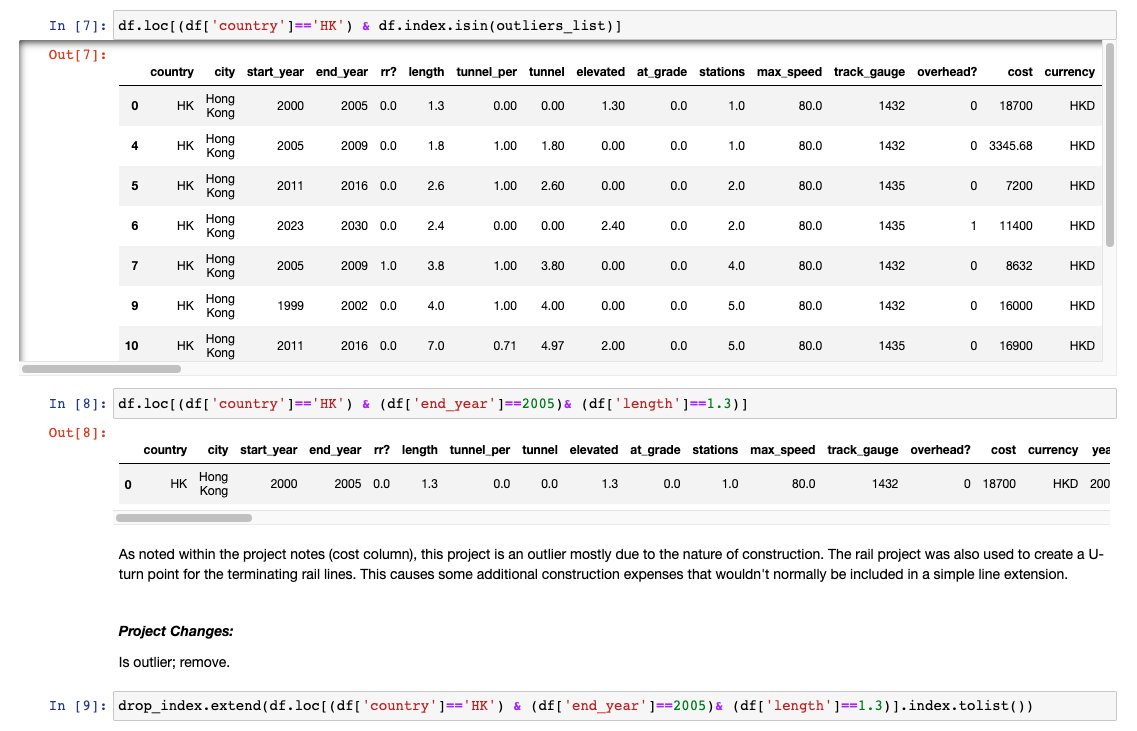

In [72]:
image = Image.open("images/refinement_workflow.png")
image

Starting by identifying each outlier within the outlier list that corresponds to the country (in this case 'HK'). I then identified each point individually by matching the country, end_year, and length with the corresponding project in the dataset. Once the project was matched, I used the dataset to identify the name of the project and then researched the individual project to verify the data.


I used this workflow, instead of using index matching, because I found that matching project characterists was more flexible than using indices. If I changed any data previous to this point, I was at risk for potentially changing the order of the indices.

At the end of this process, I found 47 datapoints to be true outliers out of a total of 119 that were in the outliers list orginally. The remaining datapoints were adjusted based on new information and a source was provided if the change represented a significant alteration of the original data.

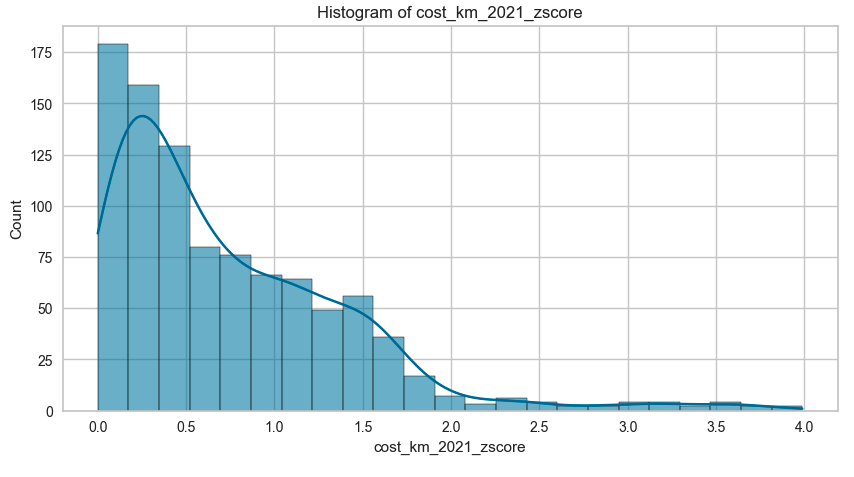

In [73]:
image = Image.open("images/z_scores_second.png")
image

After adjusting the data and removing the 47 datapoints above, the z-score plot now looks much more normally distributed.

##### Sheet 7 (Model Second Pass)

Using this adjusted data, I then re-ran the model:

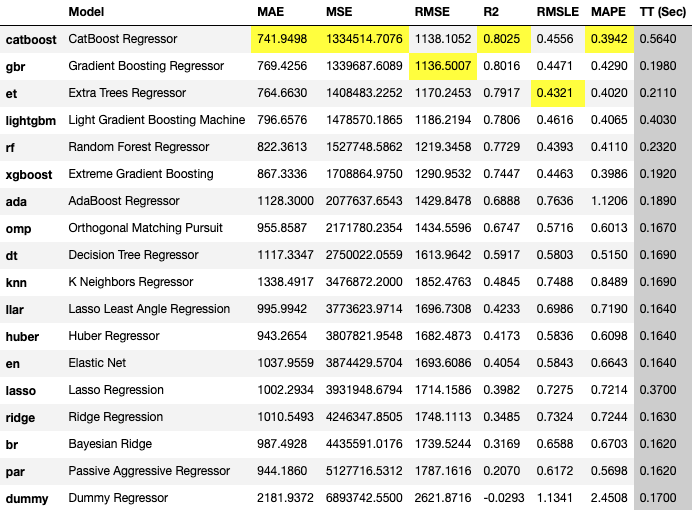

In [74]:
image = Image.open("images/model_second_pass.png")
image

The results on the second pass were significantly improved in relation to the first pass and within reason to begin refining a specific model.

The refinement process I used within this analysis was to:
1. Identify several well-performing models:
    - Purpose: Before refining, you need a baseline. Start by training several different types of models using default parameters to see which ones naturally perform better on your dataset.
    - Procedure:
        - Split the data into training and validation sets.
        - Train various models like linear regression, decision trees, random forests, gradient boosted trees, neural networks, etc., on the training data.
        - Evaluate each model's performance on the validation set using appropriate metrics (e.g., accuracy, RMSE, AUC).
        - Select models that perform well for further refinement.

2. Re-run and tune each individual model:

    - Purpose: To optimize the performance of each chosen model by finding the best hyperparameters.
    - Procedure:
        - Use techniques like grid search, random search, or Bayesian optimization to explore different hyperparameter combinations.
        - For each model type, select the hyperparameter set that gives the best performance on the validation set.
        - Retrain the model with the selected hyperparameters on the entire training dataset.
3. Apply an ensembling method to each individual model called bagging:

    - Purpose: Improve the stability and performance of each model by training multiple instances of it on different subsets of the data.
    - Procedure:
        - For each chosen model, use a method like Bootstrap Aggregating (Bagging).
        - Create multiple bootstrap samples (random subsets with replacement) from the training dataset.
        - Train an instance of the model on each bootstrap sample.
        - For predictions, average the results (for regression) or take a majority vote (for classification) across all the trained models.

4. Tune the 'bagged' model:

    - Purpose: Further refine the ensemble model to maximize its performance.
    - Procedure:
        - Adjust hyperparameters related to the bagging process. This might include the number of bootstrap samples, the size of each sample, or hyperparameters related to the way the ensemble is aggregated.
        - Use techniques from step 2 (like grid search) to explore different combinations of these bagging-related hyperparameters.

Such a structured approach, as outlined above, helps in achieving a balance between performance and overfitting and can lead to more robust and generalizable models. Many of the base models were significantly overfitting to the training data. By tuning and bagging each individual model, each model became less overfit and generalized better to unseen data.

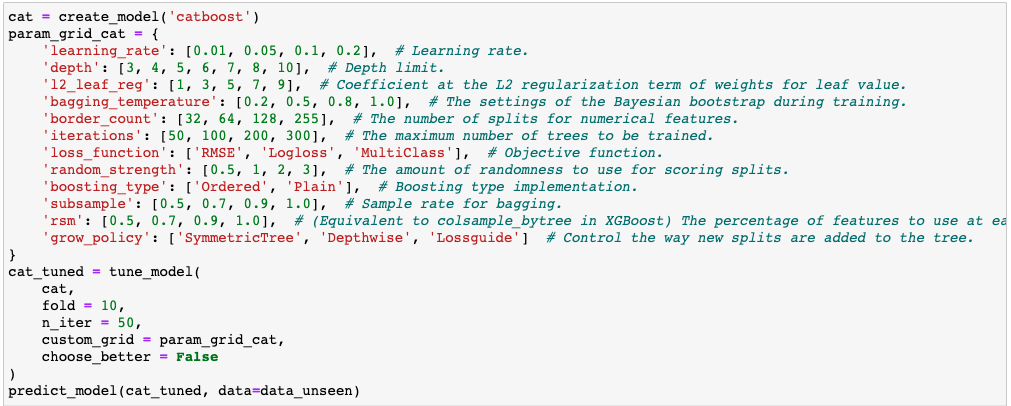

In [75]:
image = Image.open("images/model_process.png")
image

The purpose of this process is to optimize the performance of each individual model that performed well with the intent of ensembling (blending) several models together. The process of blending together several models is an ensembling technique that allows you to take advantage of the different strengths of each individual model and creates a diverse approach for identifying trends in the data. This process also can reduce overfitting if care is taken to blend models with distinct regularization mechanisms.

This process of tuning and ensembling techniques can create a more robust model, as outlined by the difference in the residuals plots.

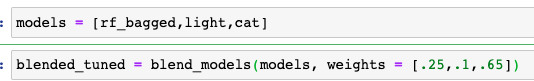

In [77]:
image = Image.open("images/models.png")
image

From above, 3 models were blended together to create the blended model used for analysis.

The first model used is a Random Forest Model which is a tree based model that can be prone to overfitting, as shown by the residuals plot below

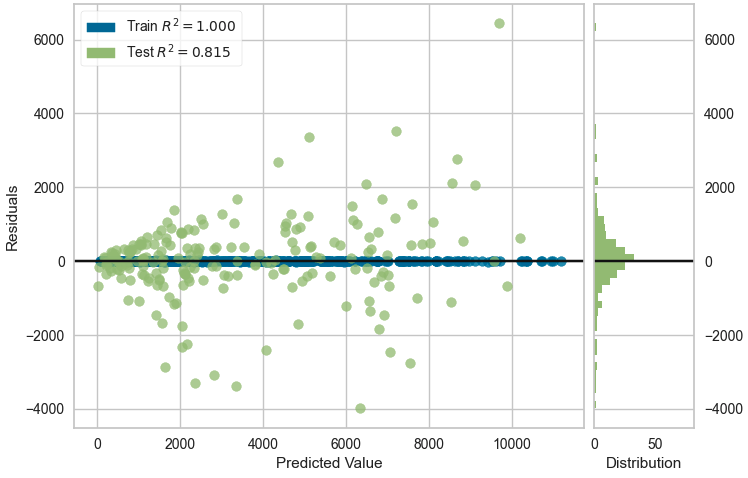

In [82]:
image = Image.open("images/model_residuals_rf.png")
image

As you can see, the base Random Forest model was perfectly overfit to the training data.

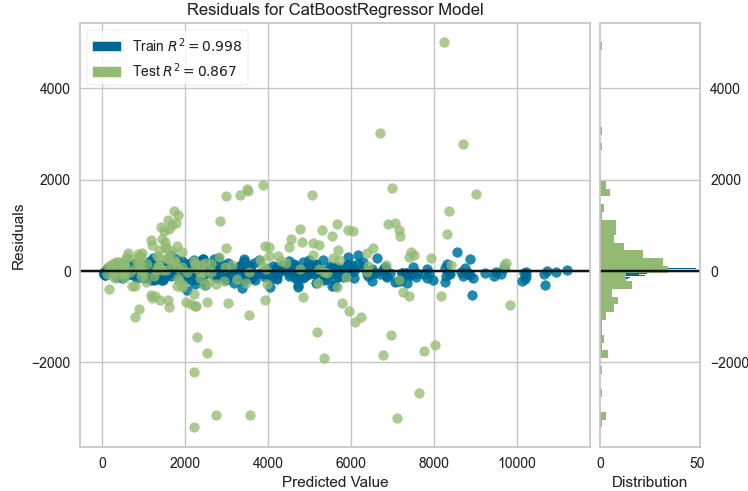

In [83]:
image = Image.open("images/model_residuals_cat.png")
image

and the CatBoost model was also significantly overfit

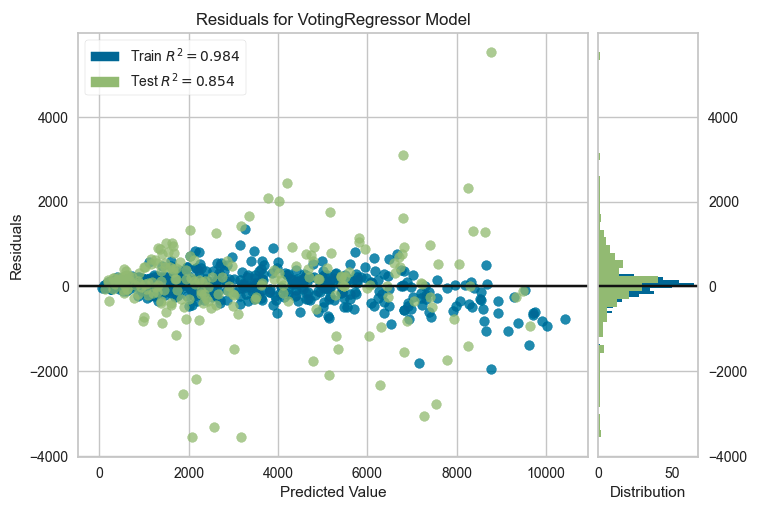

In [79]:
image = Image.open("images/model_residuals_final.png")
image

However, when the Random Forest model was tuned, bagged, and then blended with CatBoost and LightGBM models, the resulting model is much less overfit and generalized much better to unseen data (as a measure of the predictions made by each model on the holdout dataset).

##### Sheet 8 (Feature Reduction)

A noticable trait of this dataset is its wideness. The dimensionality  of the data is exceptional given the number rows available. It's possible that some features may be a hinderance to the model and that removing some features may improve accuracy, prohibit overfitting, and help the model generalize better to new data.

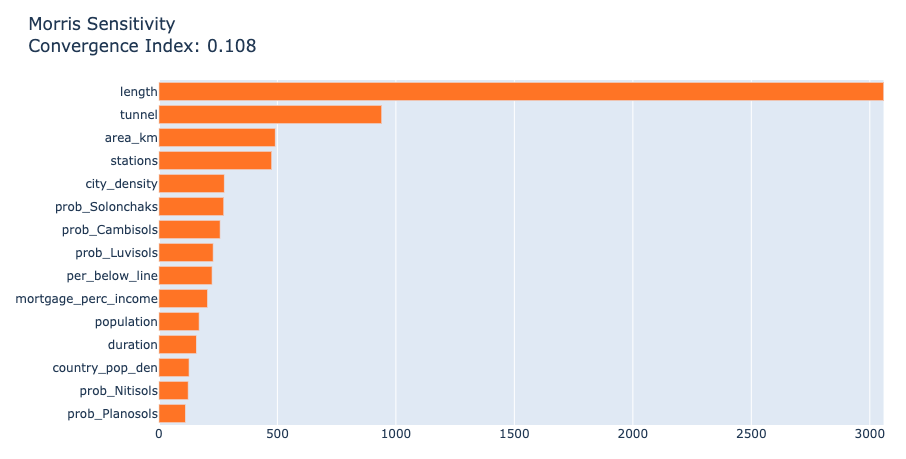

In [111]:
image = Image.open("images/Morris_sensitivity.png")
image

The Morris Sensitivity plot tells us which features impact the model. It gauges the effect of changing one input variable at a time, keeping the other inputs fixed and the sensitivity score is a measure of how sensitive the model is to changes in the underlying data.

From the plot, we can see that the 'length' component is far more 'important' than the rest of the features. The first attempt to evaluate the data using a simplified subset of the features used the top 4 features: 'length','tunnel','area_km', and 'stations'.

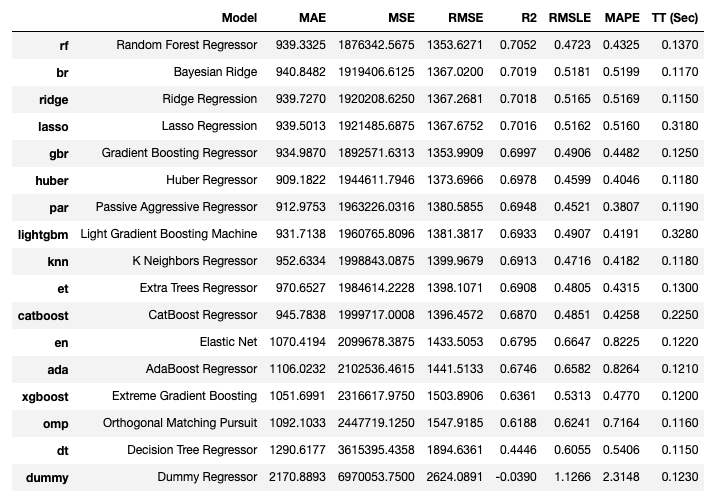

In [113]:
image = Image.open("images/model_simple_summary.png")
image

The 'simple' model using only the top 4 features achieved a worse MAE and R-squared, in relation to the full dataset.

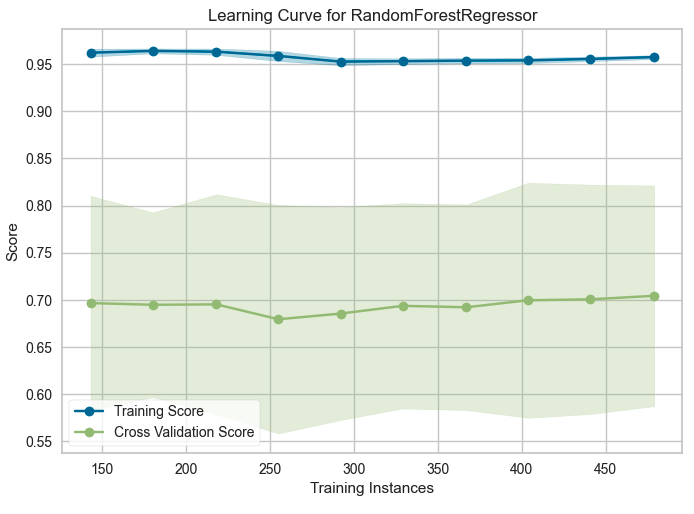

In [112]:
image = Image.open("images/learningCurve_simple.png")
image

Additionally, the learning curve showed that the model was significantly overfitting to the training data. One reason to pursue a dataset with fewer features is to mitigate for your model fitting to the noise in the data, especially if you suspect the noise is generated from features that have no correlation with the target variable.

The next step in the process was to programmatically choose the features. Within Pycaret, the setup function contains a boolean parameter that allows for the use of sklearn's 'SelectFromModel'. SelectFromModel is a meta-transformer provided by scikit-learn that can be used alongside any regressor that exposes a 'coef_' or 'feature_importances_' attribute after fitting. 

The primary purpose of SelectFromModel is to select features based on the importance weights (either coefficients or feature importances). After fitting the estimator, SelectFromModel uses a threshold to select features. Features whose importance is greater or equal to the threshold are retained, while others are discarded. The default threshold is the mean of the feature importance values.

Following the previous model run with only the top 4 features, an additional model was run using all of the features, but also toggling feature importances.

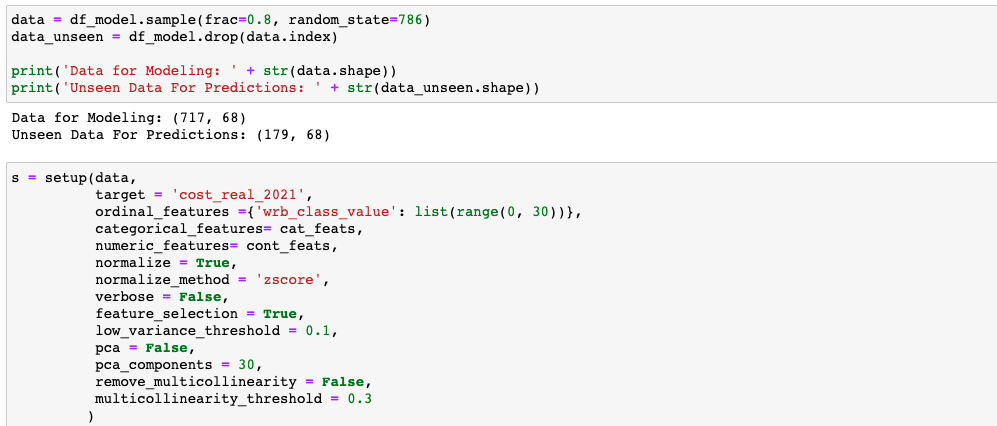

In [114]:
image = Image.open("images/feature_reduction_setup.png")
image

which resulted in a model that performed well, but not better than the previous models.

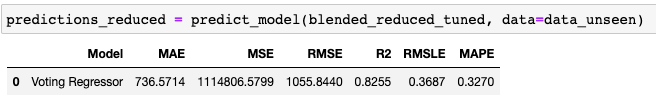

In [115]:
image = Image.open("images/model_feature_reduction.png")
image

Additionally, the resulting blended and tuned model with feature reduction toggled on was similarly overfit.

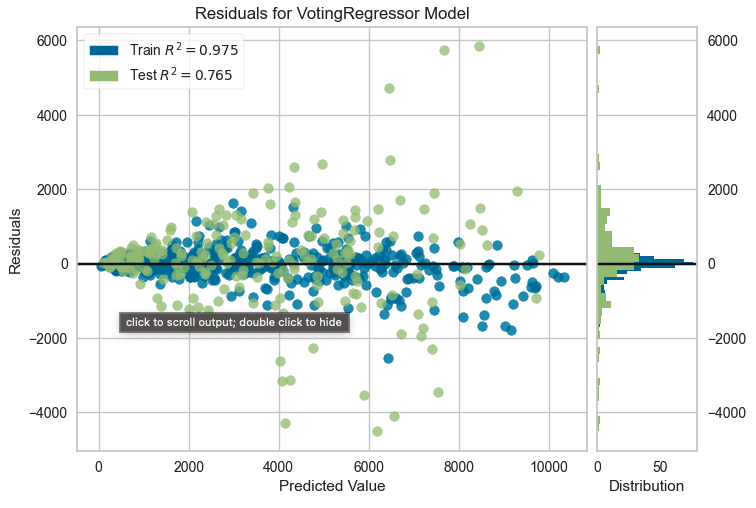

In [116]:
image = Image.open("images/residuals_reduced.png")
image

The next step was to investigate if there is a non-linear relationship between the independent and dependent variables in the dataset.

Polynomial features is a technique used in machine learning to generate interaction terms and higher-degree features from the original set of features. The idea behind this method is that a linear model can be made more flexible by adding powers of the original features, allowing it to capture more complex relationships in the data.

For instance, if we have a dataset with a single feature x, introducing a second-degree polynomial would involve not only using x but also x^2 as a feature. Similarly, for two features x and y, a second-degree polynomial would introduce terms like x^2, y^2, and xy.

Using polynomial features can be particularly helpful when the relationship between the independent and dependent variables is inherently nonlinear. By increasing the degree of the polynomial, you're essentially trying to fit the data better. However, one must be cautious as adding too many polynomial features can lead to overfitting, where the model performs very well on the training data but poorly on unseen data.

Creating polynomials of the existing features of the dataset is computationally expensive, especially as a higher degree of polynomial is applied. For this analysis, ran two additional models for 2nd and 3rd degree polynomial features.

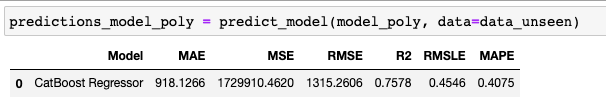

In [117]:
image = Image.open("images/model_polynomial_2.png")
image

Second degree polynomial features did not provide insight into non-linear trends, as I had hoped. The resulting model achieved worse metrics in all categories.

The model using third degree polynomial features achieved slightly better results, however still not better than the base model and was still overfit significantly (which was expected given the base model was already overfit).

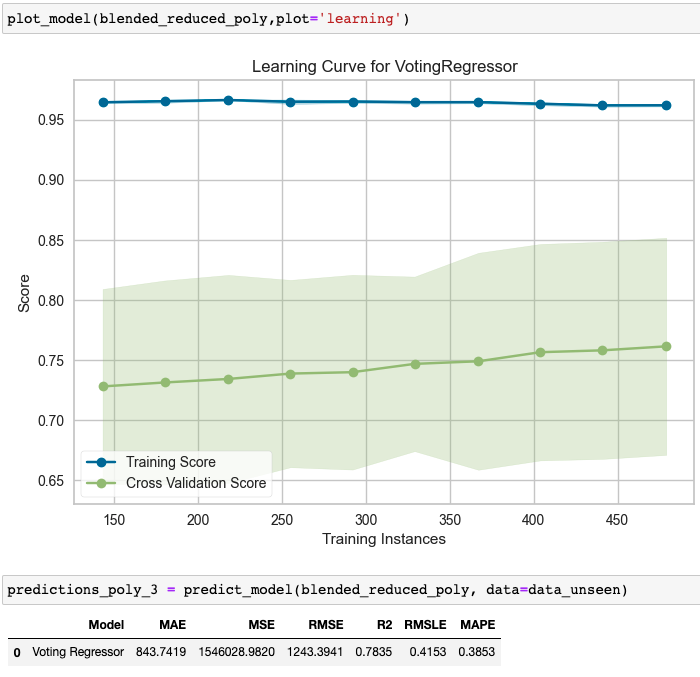

In [118]:
image = Image.open("images/model_poly_3.png")
image

Experimenting with the feature dimensionality did not return a model that was superior to models created previously and so the rest of this analysis continued with the previous model.

##### Sheet 9 (Error Analysis & Model Deployment)

Error analysis is a iterative process. The outliers present in the first model may not be significant outliers in the eyes of the blended model. So once more, I took the model created in the ensembling step and recalculated the residuals to determine if any datapoints needed to be addressed. This iteration I used standardized residuals to evaluate outliers, in addition to the Cooks Distance.

Standardized outliers refer to individual data points that deviate significantly from the mean, measured in terms of standard deviations. These outliers are often identified by z-scores, with values beyond a threshold (e.g., |z| > 2 or 3) considered potential outliers. As you can see with the plot below, the standardized_residuals are much more normal than previously.

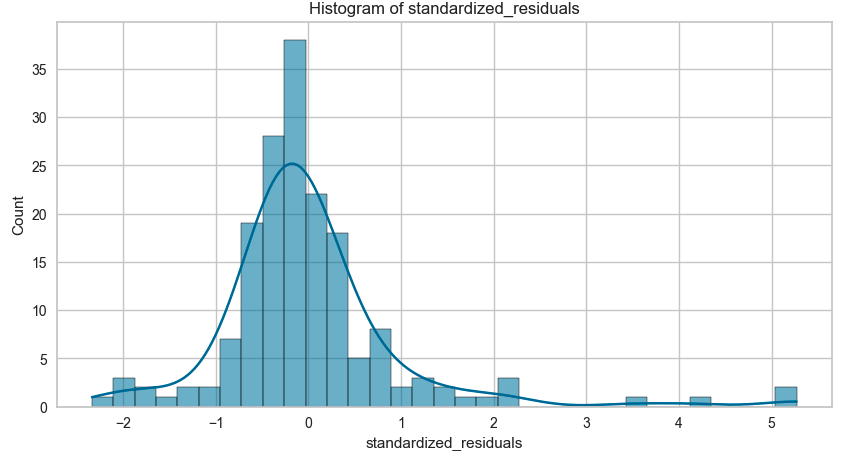

In [84]:
image = Image.open("images/z_scores_third.png")
image

Cook's Distance is a measure used in regression analysis to identify influential data points. It gauges the influence of each observation on the estimated regression coefficients. Specifically, Cook's Distance assesses the extent to which the predicted values for the dependent variable would change if a particular observation were excluded from the analysis.

A large value of Cook's Distance indicates that the observation has a significant influence on the regression model's estimates. Observations with a Cook's Distance greater than the threshold of 4/n, where n i the number of observations, can be considered influential.

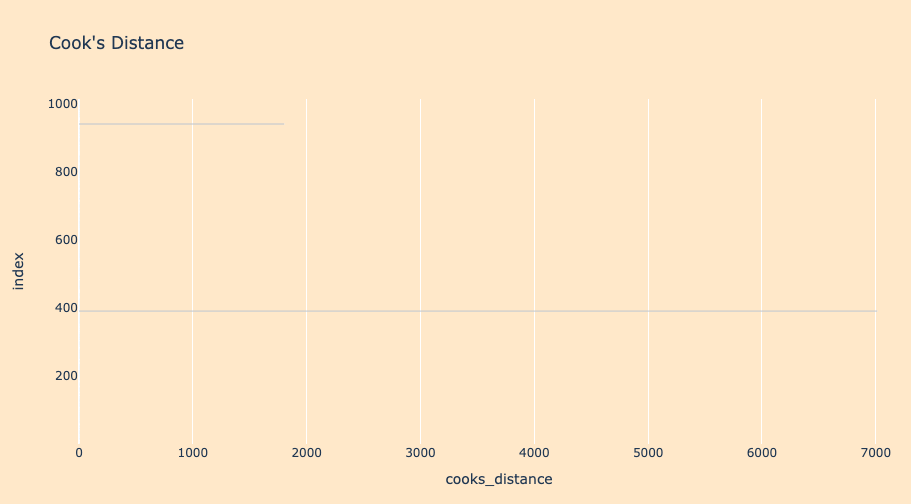

In [85]:
image = Image.open("images/cooks_distance.png")
image

The Cook's Distance plot shows only 2 values that are clear outliers. One around index 400 and the other around index 900.

By using both techniques, I was able to be more conservative with my approach to handling outliers. Since I had previously completed this process, it was important that I only remove datapoints if absolutely necessary. The second iteration through the error analysis process was similar to previous.

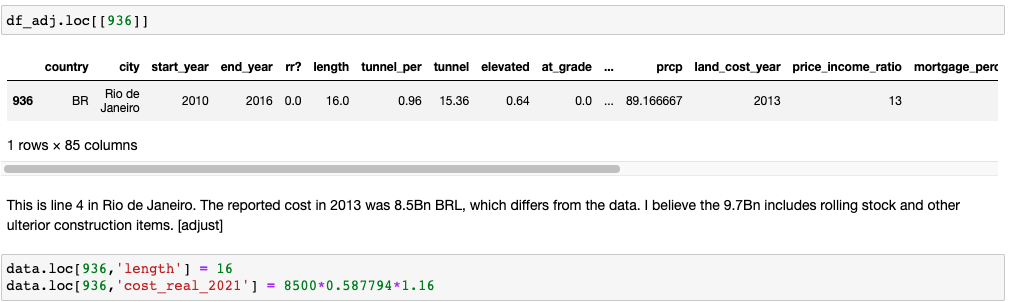

In [87]:
image = Image.open("images/error_analysis.png")
image

Identify the outlier, verify the project name, and then correct/remove the outlier. Within this iteration I removed few outliers, even if they were outside of the set thresholds. This process was, once again, completed for each value for outliers, as determined by the Cooks Distance.

After removing outliers, the final data frame has a shape of (816, 72).

With this dataset, named 'df_adj' (dataframe, adjusted), the model was re-run with the same workflow as previously used.

It was determined that a blended model of a bagged XGBoost and base CatBoost model with weights of [.2,.8] performed the best on unseen data.

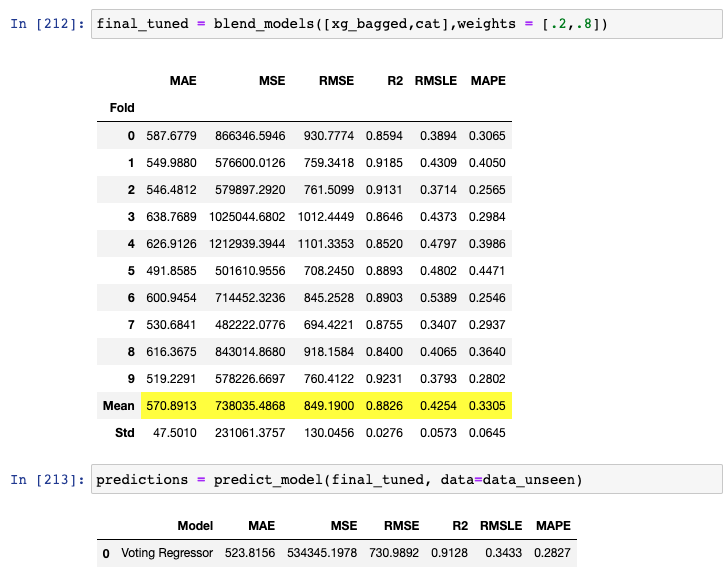

In [90]:
image = Image.open("images/model_results_1.png")
image

This model achieved an MAE of 523.81 and an R-Squared of .9128, which is an improvement over the 2nd model pass which achieved a 625.14 MAE with a .8381 R-Squared.

This model was then finalized by re-training the model on all of the data (train and test sets) and then re-evaluating the model on the unseen data.

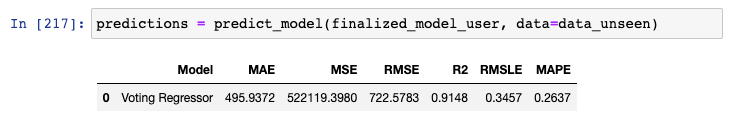

In [91]:
image = Image.open("images/model_finalized_1.png")
image

After finalizing, the model achieved better MAE on a similar R-Squared. This model was then deployed using Gradio.

##### Sheet 10 (Simplified Features)

The next step was to create a model that was more intuitive to use. In deploying the finalized model, as shown above, it was clear the deployed model required extensive knowledge of every detail of a project site.

For instance, someone wishing to use the model to predict the cost of a transit project in a given area would need to know the specific soil type probabilities and enter them for each of the 18 soil probability categories. So it was clear that this was not going to be the final model, as the purpose of this analysis was to provide a tool that anyone  could use.

My solution to this was to categorize each continuous feature, outside of track lengths and types. Instead of requiring an integer input from the user, the simplified model (user model) would provide several options for the user to choose from.

For example, within this process, the probability features were dropped and the soil type 'WRB class value' feature was used to derive a new feature called soil type.

The World Reference Base for Soil Resources (WRB) is an international soil classification system for naming soils and creating legends for soil maps. The WRB provides a common language for soil scientists to communicate the properties and usability of soils.

Within the dataset, several of these class values were represented in the data.

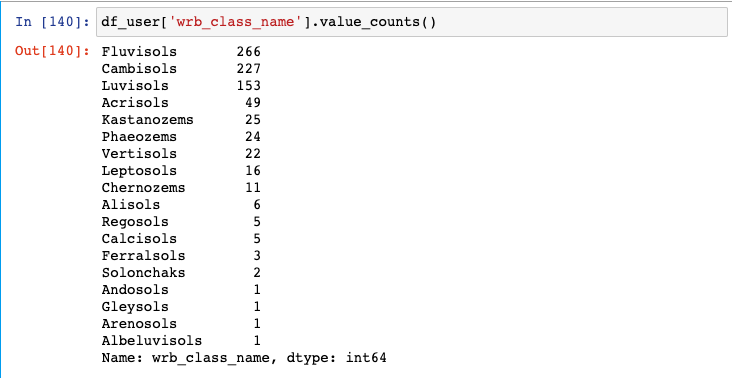

In [92]:
image = Image.open("images/soil_types.png")
image

Each individual soil type within the WRB Class list is provided a description, such as:

    - Andosols: These are soils that form in volcanic ash and are rich in minerals like aluminium and iron.
    - Arenosols: Sandy soils that have very weak or no soil structure.
    - Chernozems: Fertile black soils containing a high percentage of organic carbon, common in cool grassland regions.
    - Ferralsols: Found in humid tropical climates and characterized by a high content of iron and aluminium oxides.
    - Fluvisols: Young soils that form in alluvial deposits often found in river valleys.
    
    ...

To simplify the WRB class naming convention, new bins were created and each soil type was sorted into a bin that roughly correlated with the WRB class description. A simply python function was used to do this:

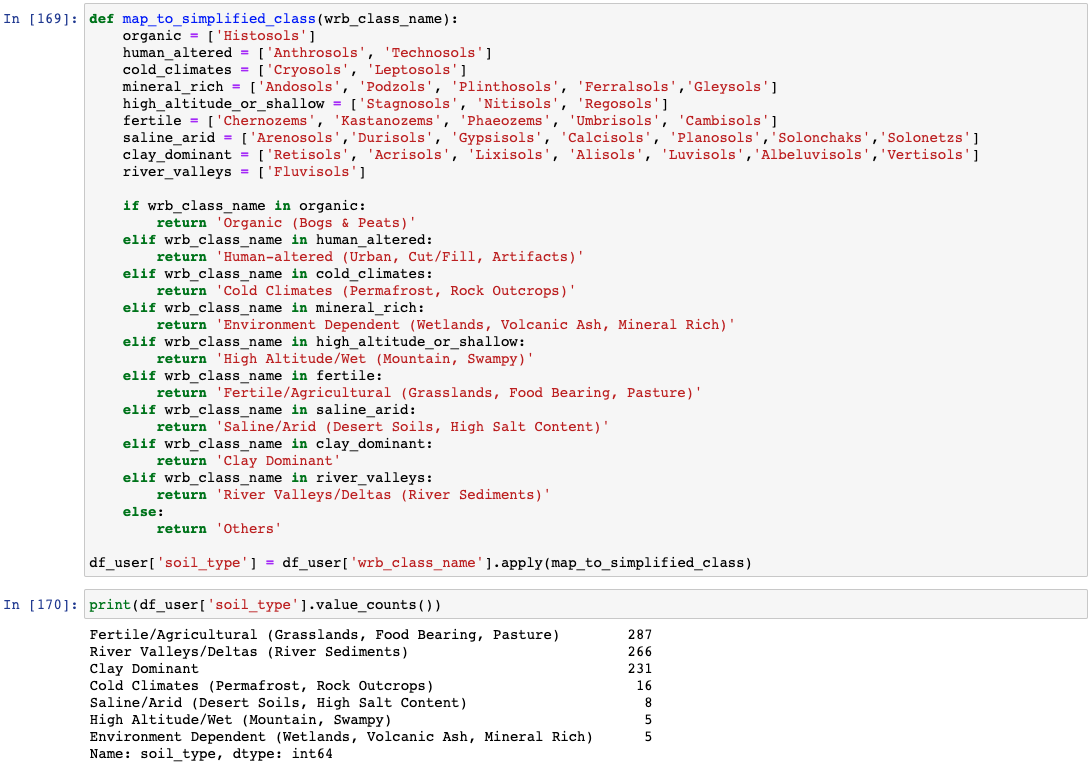

In [93]:
image = Image.open("images/soil_types_simplified.png")
image

This new feature now requires the user to provide a description of the soil, rather than provide a taxonomy of the soil itself. This process was completed for each feature, creating more easily identifiable options for the user. For instance, converting this:

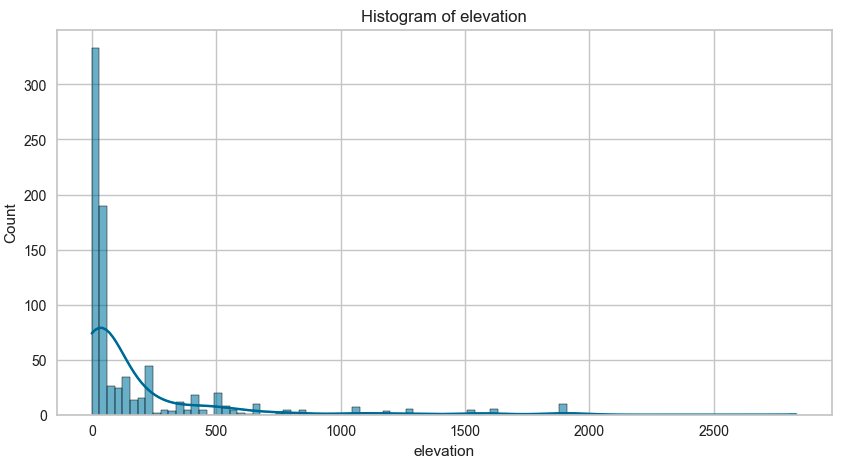

In [95]:
image = Image.open("images/elevation.png")
image

To the more easily understanable:

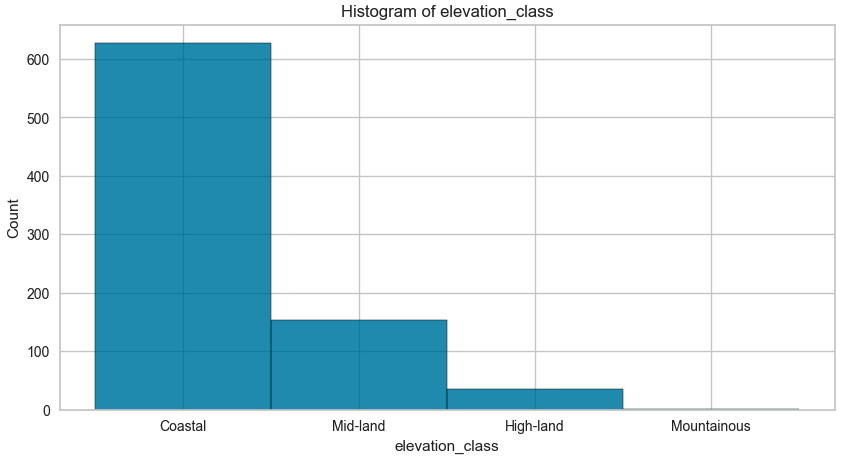

In [96]:
image = Image.open("images/elevation_simplified.png")
image

This simplified model achieved comparable metrics to the base finalized model.

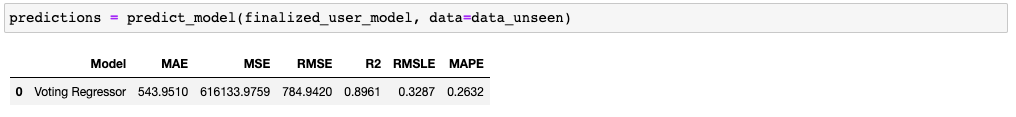

In [97]:
image = Image.open("images/model_simplified_finalized.png")
image

In comparison to the base model, which achieved an MAE of 495 and an R-Squared of .91.

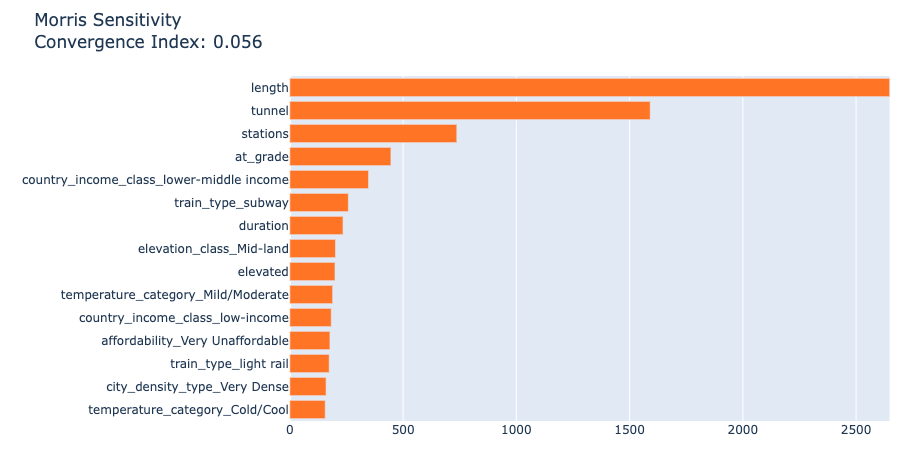

In [98]:
image = Image.open("images/Morris_sensitivity_simplified.png")
image

The Morris sensitivity analysis is a method used to screen for the most influential parameters in a computational model. The output from a Morris sensitivity analysis is often the Morris sensitivity measure (or Morris score), which gauges the effect of changing one input variable at a time, keeping the other inputs fixed.

The Morris Sensitivity for this model was .056, which implies that the sensitivity of the model was relatively insensitive to changes in independent variables. It's also positive, which indicates that increases in the independent variables (length, duration, etc) would result in an increase in the dependent variable (total cost)

This simplified model was then deployed again using Gradio:

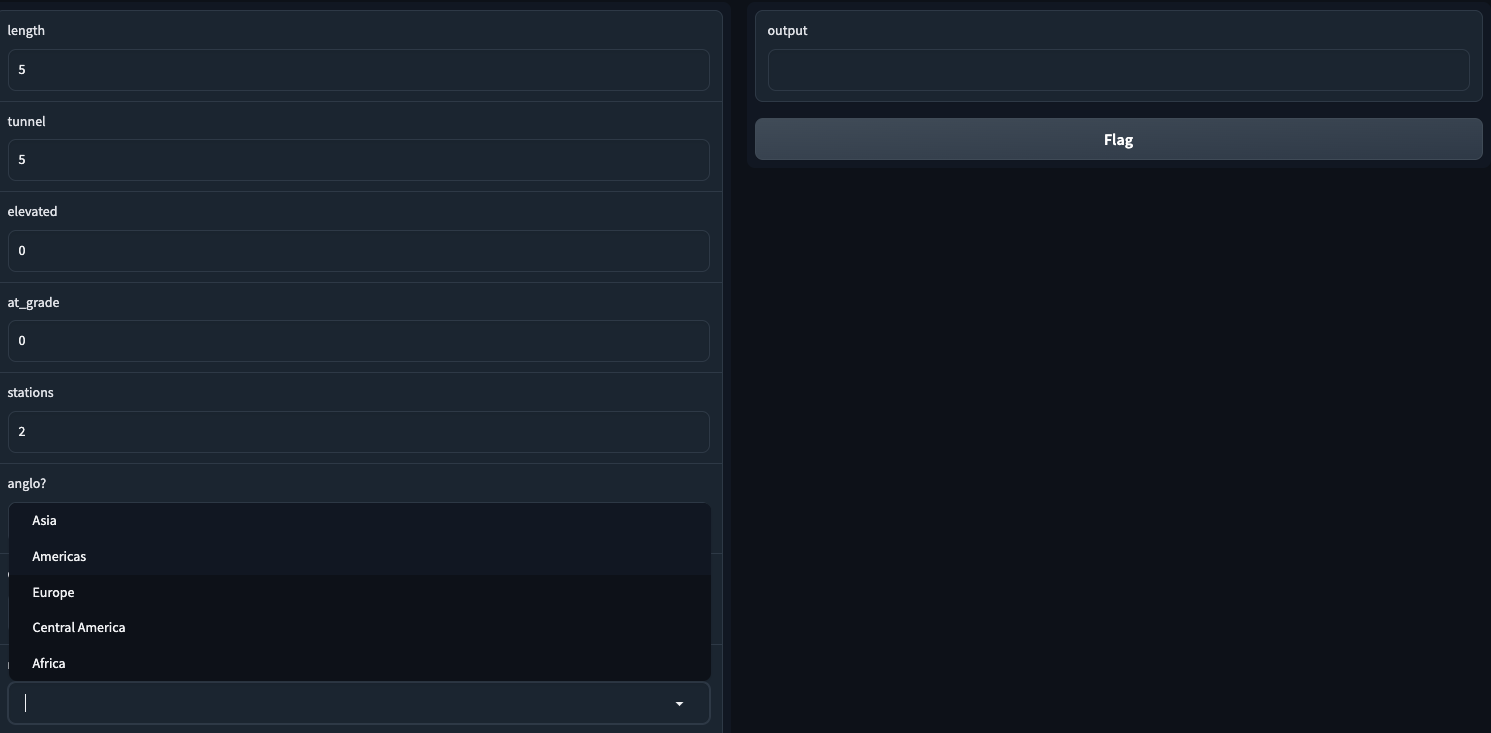

In [100]:
image = Image.open("images/gradio_simplified.png")
image

The above screenshot shows the drop-down menus for each feature. Within the project folder, the finalized user model is saved as 'finalized_user_model'.

##### Sheet 11 (Model Validity)

Within this sheet, the validity of the model was evaluated. This process involved plotting the residuals of the finalized user model and evaluating them against the model predictions. It's important that the residuals are randomly distributed around 0, as any discernable trends within the residuals would imply that the model is:

1) Inadequate and not capturing the underlying structure of the data.
2) Displaying inconsistency in error, such that variance of the model's error isn't consistent across all features.
3) Displaying seasonality, such that the model is unable to derive enough of a pattern from time data.
4) Displaying the effects of unmitigated outliers.
5) Displaying multicollinearity, where there is a high correlation amoungst independent variables.

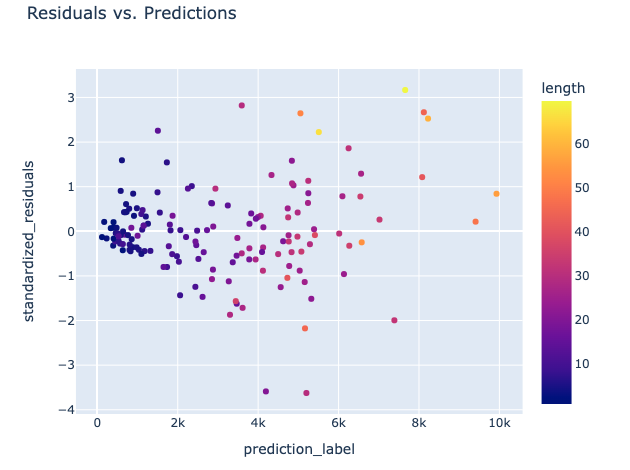

In [101]:
image = Image.open("images/residuals.png")
image

The residuals plot for the finalized model was sufficiently randomized around 0. Additionally, the residuals plot for each individual feature displayed a similar distribution.

Due to the small size of the dataset, it's important to note that the distributions of each feature may not be perfectly 'normal' as there simply isn't enough data within each subset of each feature.

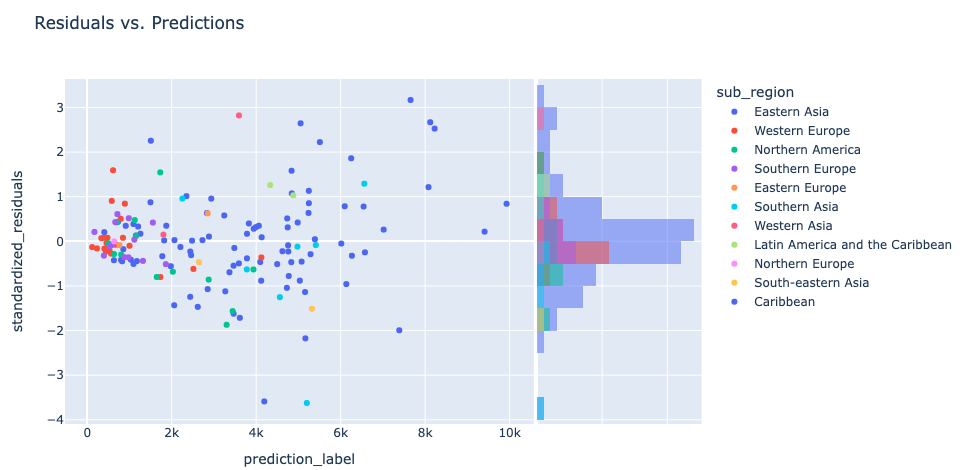

In [102]:
image = Image.open("images/residuals_features.png")
image

However, in the above plot we can see that the values for the 'sub_region' feature are generally distributed around 0 and each of the feature labels are represented within each tier of the distribution.

Additionally, as discussed previously, the finalized user model was not significantly overfit. Overfitting occurs when a model captures not only the underlying patterns in the data but also the random noise or fluctuations.

In an overfit model, the model is overly tailored to the specific dataset it was trained on. As a result, while it may perform exceptionally well on that training dataset, its performance on new, unseen data (often referred to as "test data" or "out-of-sample data") tends to be poorer. To verify that the model is not overfitting, we can compare the performance of the model on the "seen" data (the data it saw during training) to the performance of the model on unseen data.

The model performed similar on the unseen data:

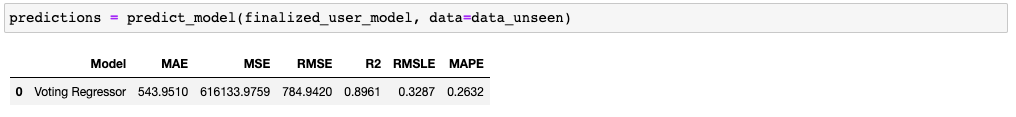

In [103]:
image = Image.open("images/model_simplified_finalized.png")
image

as it did on the "seen" data:

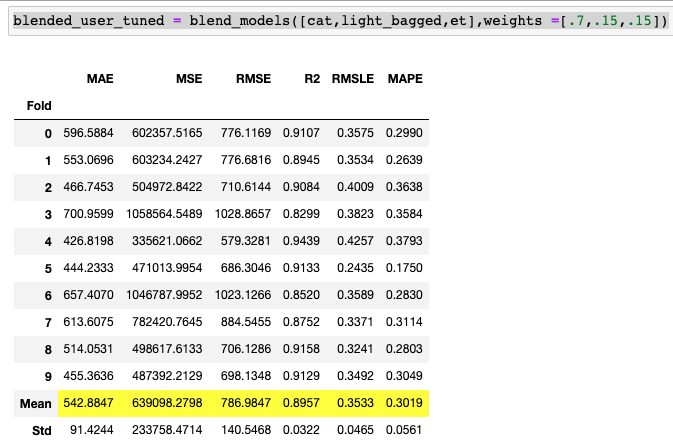

In [106]:
image = Image.open("images/model_user_seen.png")
image

Which implies that the model is not overfitting to the training data and will generalize well to unseen data.

### Conclusion

The purpose of this analysis was to evaluate available data pertaining to the construction of Metro systems around the world and to produce a model that can estimate the cost for future Metro projects, given some data about the project. The resulting model is an successful first iteration towards achieving this goal.

The finalized user model achieves both goals set at the outset of this analysis as it is both 1) relatively accurate and 2) easily understandable.

The accuracy achieved by the model with a mean absolute error of 543.95M USD and an R-squared of .896 is sufficient for the purposes of creating a user focused model that can estimate the potential cost for a project in a given area. 

In [110]:
combined_metrics

,Model,Version,Dataset,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Model First Pass,M_A1,Base df,3081.4006,2.286676e+08,15121.7602,-3.2391,0.6967,0.6576
1,CatBoost Base (After 1st Pass Outlier Removal),M_B1,df_adj,644.6227,1.222307e+06,1105.5800,0.8296,0.4249,0.3163
2,CatBoost Tuned,M_B2,df_adj,718.8183,1.421751e+06,1192.3719,0.8018,0.4680,0.4183
3,CatBoost Bagged,M_B3,df_adj,718.8183,1.421751e+06,1192.3719,0.8018,0.4680,0.4183
4,Blended,M_B4,df_adj,666.0686,1.316413e+06,1147.3505,0.8164,0.3772,0.3169
5,Blended & Tuned,M_B5,df_adj,650.6519,1.276483e+06,1129.8153,0.8220,0.3705,0.3065
6,CatBoost Model + Feature Reduction,M_C1,df_adj,744.1359,1.116342e+06,1056.5707,0.8252,0.3749,0.3384
7,CatBoost Model + 2nd Degree Polynomial Features,M_C2,df_adj,903.4904,1.683482e+06,1297.4908,0.7643,0.4298,0.3967
8,CatBoost Model + 3rd Degree Polynomial Features,M_C3,df_adj,843.7419,1.546029e+06,1243.3941,0.7835,0.4153,0.3853
9,Cat+XG (2nd Pass Outlier Removal),M_D1,df_user,521.4628,5.342466e+05,730.9217,0.9128,0.3436,0.2812


### Potential Improvements

There are several ways to improve the reliability of the model which would likely reduce the variance of the output and the accuracy of the model on unseen data:

1) Dataset size
    - The overall size of the dataset is very small, relative to what is needed to generate a (more) meaningful model that can reliably generate accurate predictions.
    - The dataset itself is somewhat Asia centric, which may skew the predictions for other locales. Increasing the size of the dataset would help in this regard.
    
2) Dataset accuracy
    - In many cases, the accuracy of the underlying data could be improved. This is less an issue of data collection, as often there were few sources to verify the details of a project.
    - With more resources and expertise, I would have spent more time at the outset creating tools to verify the data and to create means to handle highly variable components (inflation rate, PPP rates)
    - There exists a better solution to handle data verification that I would like to explore further.
    
3) Expansion of existing features
    - In my attempts to engineer features from the existing data, it's possible that there are other combinations of engineered features that could have yielded better insight for the model. My attempts with feature engineering were not exhaustive.
    - I wasn't able to find a proxy that correlated strongly enough with land aquisition prices. I believe this is an important component that would help the model generalize better with fewer features.

### Sources & Acknowedgments

Within the analysis I've summarized above, I relied heavily on several external sources. Each source I list below was invaluable and I'm gratful for their contributions to the world.

1. [The Transit Project](https://transitcosts.com/about/)
2. [Pedestrian Observations](https://pedestrianobservations.com/)
3. [PyCaret](https://pycaret.gitbook.io/docs/)
4. [Urban Rail](https://www.urbanrail.net/)
5. [Soil Grids](https://www.isric.org/explore/soilgrids)
6. [Plotly](https://plotly.com/python/)
7. [OpenMeteo](https://open-meteo.com/)
8. [Gradio](https://www.gradio.app/)